# Project Overview

Using AI Platform Notebooks to build and train a model for identifying fraudulent transactions, and understand the model's predictions with the Explainable AI SDK. Fraud detection is a type of anomaly detection specific to financial services, and presents some interesting challenges for ML models: inherently imbalanced datasets and a need to explain a model's results.

# Set up the environment

In [1]:
#Installing libraries
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import explainable_ai_sdk

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
print("It's done")

It's done


# Download and process data

In [ ]:
!gsutil cp gs://financial_fraud_detection/fraud_data_kaggle.csv .

In [27]:
data = pd.read_csv('fraud_data_kaggle.csv')
data = data.drop(columns=['type'])
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [3]:
#Accounting for imbalanced data
fraud = data[data['isFraud'] == 1]
not_fraud = data[data['isFraud'] == 0]

In [4]:
# Take a random sample of non fraud rows
not_fraud_sample = not_fraud.sample(random_state=2, frac=.005)

# Put it back together and shuffle
df = pd.concat([not_fraud_sample,fraud])
df = shuffle(df, random_state=2)

# Remove a few columns (isFraud is the label column we'll use, not isFlaggedFraud)
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])

# Preview the updated dataset
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
5777870,400,65839.41,0.00,0.00,0.0,0.0,0
6362412,726,561446.32,561446.32,0.00,0.0,0.0,1
5927827,404,3828.08,10455.17,6627.09,0.0,0.0,0
5987904,410,557950.06,557950.06,0.00,0.0,0.0,1
5706694,398,1376.57,368349.14,366972.57,0.0,0.0,0


In [5]:
#Split the data into train and test sets
train_test_split = int(len(df) * .8)

train_set = df[:train_test_split]
test_set = df[train_test_split:]

train_labels = train_set.pop('isFraud')
test_labels = test_set.pop('isFraud')

In [6]:
print(train_test_split)

31988


# Build, train, and evaluate a tf.keras model 

In [7]:
#Normalize the data
scaler = StandardScaler()
train_set = scaler.fit_transform(train_set) # Only normalize on the train set
test_set = scaler.transform(test_set)

# clip() ensures all values fall within the range [-5,5]
# useful if any outliers remain after normalizing
train_set = np.clip(train_set, -5, 5)
test_set = np.clip(test_set, -5, 5)

In [8]:
train_set

array([[ 0.78221227, -0.28135938, -0.32757956, -0.25881048, -0.27127608,
        -0.30545202],
       [ 2.72626487,  0.0828357 , -0.13994077, -0.25881048, -0.27127608,
        -0.30545202],
       [ 0.80606567, -0.3269282 , -0.32408538, -0.25634649, -0.27127608,
        -0.30545202],
       ...,
       [-1.53753148, -0.08614054, -0.24469344, -0.25881048, -0.20257442,
        -0.1371838 ],
       [-0.78614918,  1.96065359,  0.7140853 , -0.25881048, -0.14910874,
         0.55889324],
       [-0.60724864, -0.14519116, -0.24364672, -0.25881048, -0.27127608,
        -0.30545202]])

In [9]:
#Determine class weights
weight_for_non_fraud = 1.0 / df['isFraud'].value_counts()[0]
weight_for_fraud = 1.0 / df['isFraud'].value_counts()[1]

class_weight = {0: weight_for_non_fraud, 1: weight_for_fraud}

In [10]:
#Train and evaluate the model
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS):
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_set.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [11]:
EPOCHS = 100
BATCH_SIZE = 512

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [12]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                112       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


C:\Users\jhose\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
results = model.fit(
    train_set,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(test_set, test_labels),
    class_weight=class_weight)

Epoch 1/100
63/63 [==============================] - 2s 9ms/step - loss: 3.6206e-05 - tp: 3135.0000 - fp: 11327.0000 - tn: 14042.0000 - fn: 3484.0000 - accuracy: 0.5370 - precision: 0.2168 - recall: 0.4736 - auc: 0.5088 - val_loss: 0.6600 - val_tp: 767.0000 - val_fp: 1803.0000 - val_tn: 4600.0000 - val_fn: 827.0000 - val_accuracy: 0.6711 - val_precision: 0.2984 - val_recall: 0.4812 - val_auc: 0.5937
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 3.2029e-05 - tp: 3926.0000 - fp: 9031.0000 - tn: 16338.0000 - fn: 2693.0000 - accuracy: 0.6335 - precision: 0.3030 - recall: 0.5931 - auc: 0.6576 - val_loss: 0.6108 - val_tp: 1164.0000 - val_fp: 929.0000 - val_tn: 5474.0000 - val_fn: 430.0000 - val_accuracy: 0.8301 - val_precision: 0.5561 - val_recall: 0.7302 - val_auc: 0.8602
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 2.9805e-05 - tp: 4133.0000 - fp: 6623.0000 - tn: 18746.0000 - fn: 2486.0000 - accuracy: 0.7152 - precision: 0.3843 - recal

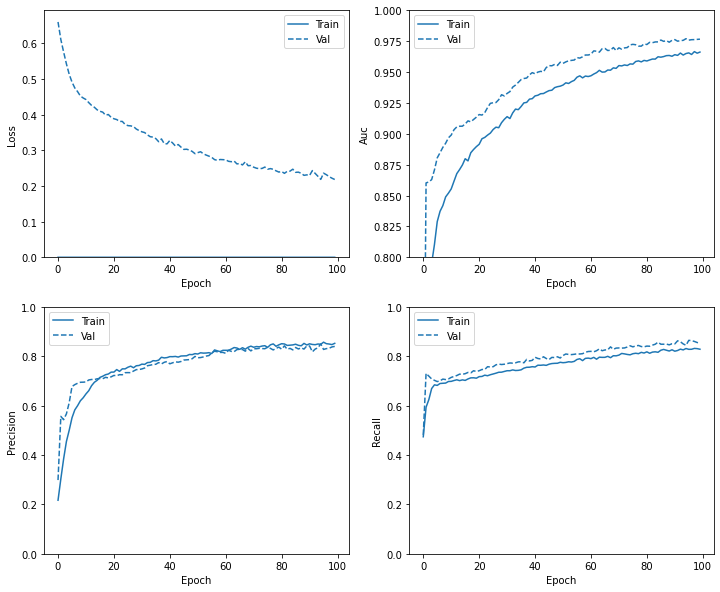

In [14]:
#Visualize model metrics
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(results)

In [15]:
#Print a confusion matrix
predicted = model.predict(test_set)

y_pred = []

for i in predicted.tolist():
  y_pred.append(int(round(i[0])))

250/250 [==============================] - 0s 690us/step


In [16]:
cm = confusion_matrix(test_labels.values, y_pred)
print(cm)

[[6143  260]
 [ 236 1358]]


In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

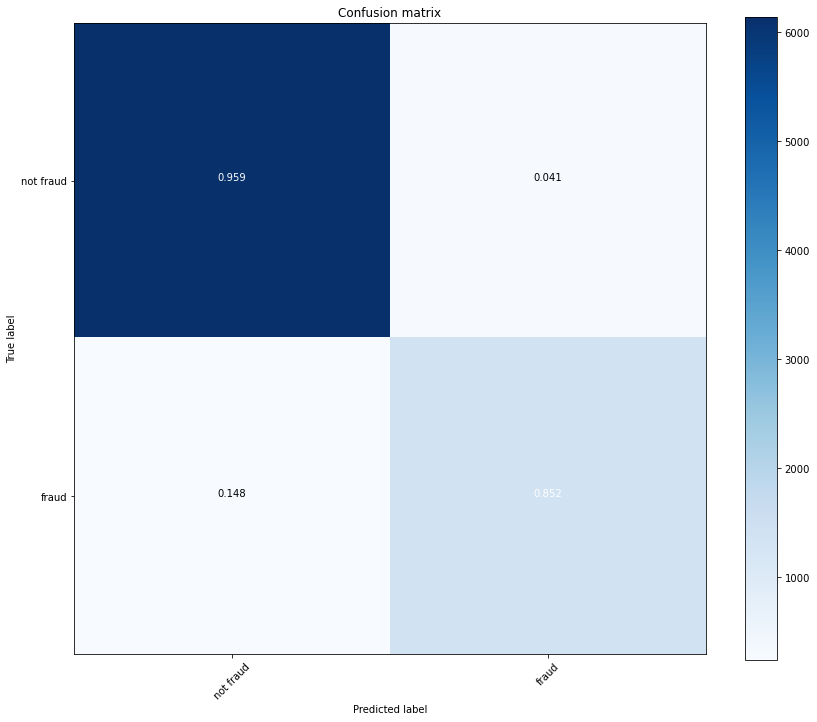

In [18]:
classes = ['not fraud', 'fraud']
plot_confusion_matrix(cm, classes, normalize=True)

# Using the Explainable AI SDK 

In [19]:
#Export trained model
model_dir = 'fraud_model'
tf.saved_model.save(model, model_dir)

INFO:tensorflow:Assets written to: fraud_model\assets


In [20]:
#Get explanation metadata with the SDK
model_builder = SavedModelMetadataBuilder(model_dir)
metadata = model_builder.get_metadata()
print(metadata)

{'outputs': OrderedDict([('dense_1', {'output_tensor_name': 'dense_1'})]), 'inputs': OrderedDict([('dense_input', {'input_tensor_name': 'dense_input', 'encoding': 'identity', 'modality': 'numeric'})]), 'framework': 'tensorflow2', 'tags': ['explainable_ai_sdk']}


In [21]:
#Specifying our model's baseline
not_fraud_sample = not_fraud_sample.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud', 'isFraud'])

baseline = scaler.transform(not_fraud_sample.values)
baseline = np.clip(baseline, -5, 5)
baseline_values = np.median(baseline, axis=0)

C:\Users\jhose\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [22]:
input_name = list(metadata['inputs'])[0]
model_builder.set_numeric_metadata(input_name, input_baselines=[baseline_values.tolist()], index_feature_mapping=df.columns.tolist()[:6])
model_builder.save_metadata(model_dir)

# Thank you!